## import packages

In [1]:
# import packages
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import cv2

## Download dataset and Visualize

In [38]:
import torch.utils
import torch.utils.data


transform = transforms.Compose([transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

All_Train_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=True, download=False, transform=transform)
Test_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=False, download=False, transform=transform)

In [50]:
print(np.bincount(test_labels))

[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [42]:
# Split Traindata and Validdata
from sklearn.model_selection import StratifiedShuffleSplit
train_labels = np.array(All_Train_dataset.targets)
test_labels = np.array(Test_dataset.targets)
# Grantee same proportion
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)


indics = np.array(len(train_labels))
train_indices, valid_indices = next(sss.split(np.zeros(indics), train_labels))

train_dataset = torch.utils.data.Subset(All_Train_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(All_Train_dataset, valid_indices)

In [53]:
# np.bincount: Count the number of occurrences of different integers
print(np.bincount(train_labels[train_indices]))

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


# Visualize the distribution of the data and the images

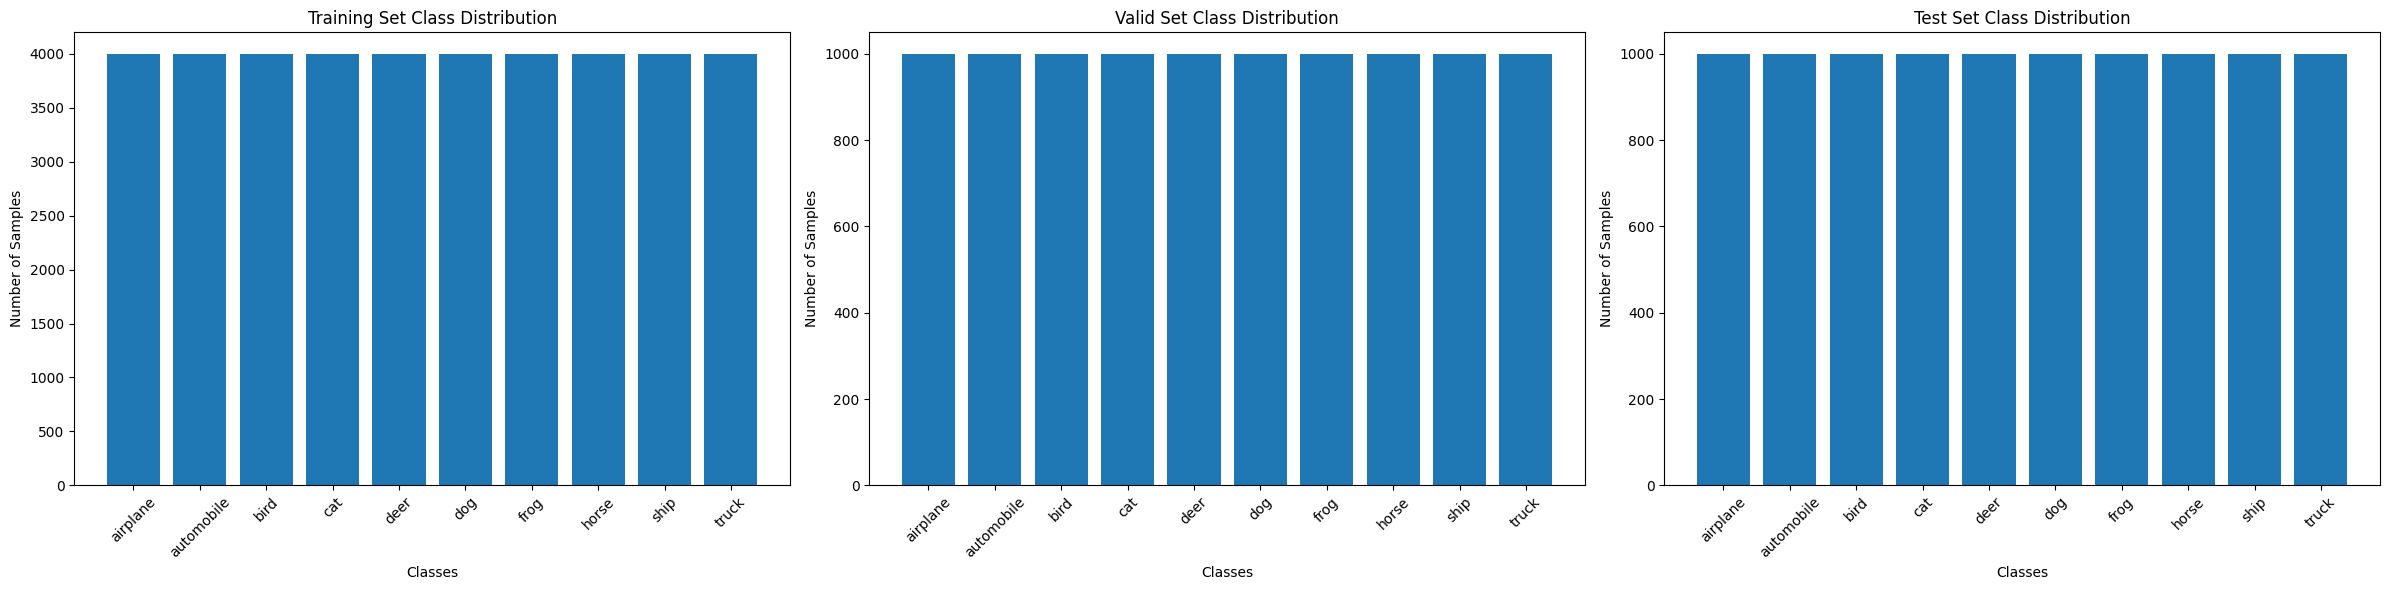

In [52]:
# Visualize the distribution of train dataset
# The CIFAR-10 dataset consists of 
# 60000 32x32 colour images
# 10 classes, 
# 6000 images per class.

# Visualization
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Train class distribution
axes[0].bar(class_labels, np.bincount(train_labels[train_indices]))
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Valid class distribution
axes[1].bar(class_labels, np.bincount(train_labels[valid_indices]))
axes[1].set_title('Valid Set Class Distribution')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)

# Test class distribution
axes[2].bar(class_labels, np.bincount(test_labels))
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Number of Samples')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

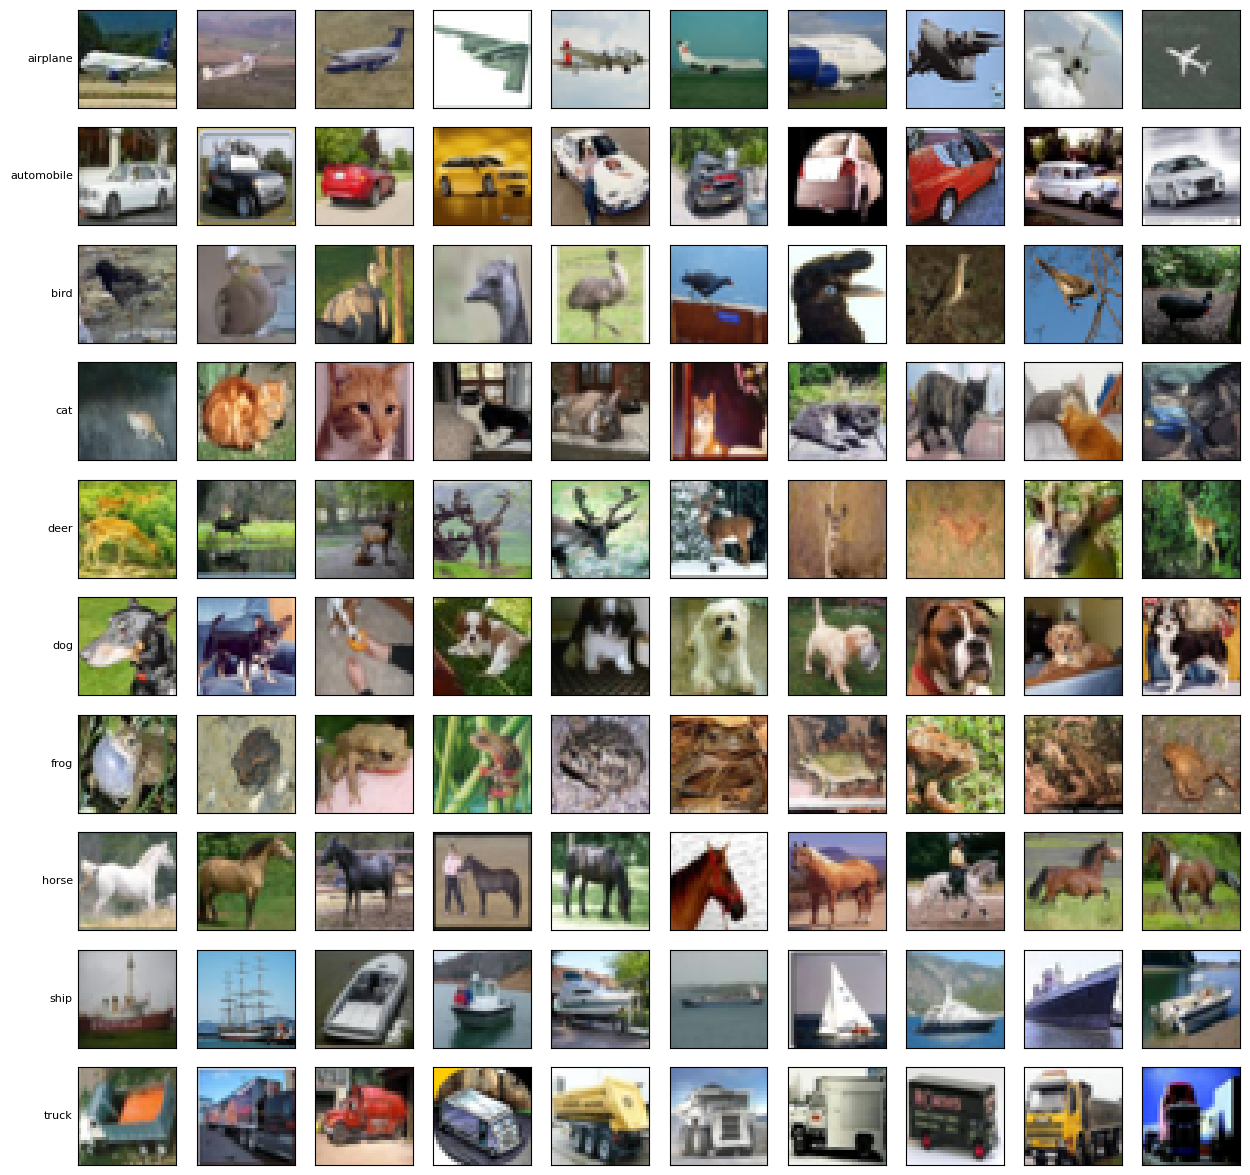

In [ ]:
# store images by class
Train_class_images = {i: [] for i in range(10)}
for img, label in train_dataset:
    Train_class_images[label].append(img)

# visualize 10 images per class
num_images = 10
fig, axes = plt.subplots(10, num_images, figsize=(15, 15))

# Set y axis labels
y_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    for j in range(num_images):
        # Restore image
        img = np.transpose((Train_class_images[i][j]*0.5 + 0.5).numpy(), (1, 2, 0))
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
    axes[i, 0].set_ylabel(y_labels[i], rotation=0, ha='right', va='center', fontsize=8)

plt.show()


### Implement KNN

In [58]:
def Knn_classifier(train_images, train_labels, test_images, k=5):
    predictions=[]
    for test_image in test_images:
        # 1. Compute Euclidean distance
        distances = np.sqrt(np.sum((train_images - test_images) ** 2), axis=1)
        # 2. Get indices of k nearest images
        nearest_indices = np.argpartition(distances, k)[:k]
        # 3. Get k labels
        nearest_labels = train_labels[nearest_indices]
        # 4. Get majority voting labels
        majority_label = Counter(nearest_labels).most_common(1)[0][0]
        predictions.append(majority_label)
    return np.array(predictions)

def Knn_classifier_cdist(train_images_tensor, train_labels, test_images_tensor, k=5):
    predictions=[]
    # 1. Compute Euclidean distance by torch.cdist
    distances = torch.cdist(test_images_tensor, train_images_tensor)
    # 2. Get indices of k nearest images
    nearest_indices = torch.topk(distances, k=k, largest=False, dim=1).indices
    # 3. Get k labels
    nearest_labels = train_labels[nearest_indices]
    # 4. Get majority voting labels
    for labels in nearest_labels:
        majority_label = Counter(labels).most_common(1)[0][0]
        predictions.append(majority_label)
    return np.array(predictions)

def Knn_classifier_cosine(train_images_tensor, train_labels, test_images_tensor, k=5):
    predictions = []
    
    # 1. normalize images to use cosine distance
    train_images_norm = train_images_tensor / torch.norm(train_images_tensor, dim=1, keepdim=True)
    test_images_norm = test_images_tensor / torch.norm(test_images_tensor, dim=1, keepdim=True)
    
    # 2. Compute consine distance
    similarities = torch.mm(test_images_norm, train_images_norm.T)  
    
    # 3. Get indices of k nearest images
    nearest_indices = torch.topk(similarities, k=k, largest=True, dim=1).indices
    # 4. Get k labels
    nearest_labels = train_labels[nearest_indices]
    
    # 5. Get majority voting labels
    for labels in nearest_labels:
        majority_label = Counter(labels).most_common(1)[0][0]
        predictions.append(majority_label)
    
    return np.array(predictions)

In [61]:
# Select best K by Valid dataset
def select_k(train_imges, train_labes, valid_images, valid_labels, model):
    best_k = None
    best_accuracy = 0
    for k in [1, 5, 10, 15]:
        val_pred = model(train_imges, train_labels, valid_images,k)
        accuracy = np.mean(val_pred == valid_labels)
        print(f"k={k}, Val accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
    
    print(f"Best k is {best_k}, and its accuracy is {best_accuracy}")
    return best_k

In [57]:
# transform data
def preprocess_data(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy().flatten())
        labels.append(label)
    
    return np.array(images), np.array(labels)


# Train data
train_images, train_labels = preprocess_data(train_dataset)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)

# Valid data
valid_images, valid_labels = preprocess_data(valid_dataset)
valid_images_tensor = torch.tensor(valid_images, dtype=torch.float32)

# Test data   
test_images, test_labels = preprocess_data(Test_dataset)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)

In [62]:
# Test KNN
# 1.Find best k
best_k = select_k(train_images_tensor, train_labels, valid_images_tensor, valid_labels, Knn_classifier_cdist)

test_pred = Knn_classifier_cdist(train_images_tensor, train_labels, test_images_tensor, best_k)
test_acc = np.mean(test_pred == test_labels)

print(f"Test accucacy is {test_acc} with k = {best_k}")


k=1, Val accuracy: 0.3454
k=5, Val accuracy: 0.3501
k=10, Val accuracy: 0.3450
k=15, Val accuracy: 0.3393
Best k is 5, and its accuracy is 0.3501
Test accucacy is 0.3486 with k = 5


### Implement Linear Classifier